# Imports

In [1]:
import os

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import neptune
from dotenv import load_dotenv
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import graphviz
graphviz.set_jupyter_format('png')
from torchview import draw_graph

In [2]:
load_dotenv()

# device = "cuda"
device = "mps"

# Dataset

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [4]:
BATCH_SIZE = 64
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Shape: [1, 28, 28]
Range: [0.0, 1.0]


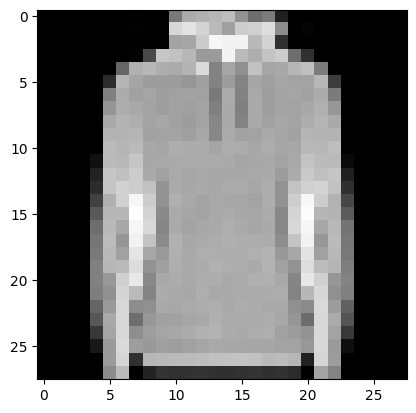

Label: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


In [5]:
example_images, example_labels = next(iter(train_dataloader))
idx = 0
img = example_images[idx]

print(f"Shape: {list(img.shape)}")
print(f"Range: [{np.amin(img.numpy())}, {np.amax(img.numpy())}]")
plt.imshow(img.permute(1,2,0), cmap='gray')
plt.show()

print(f"Label: {example_labels[idx]}")

# Model

In [6]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3),
            nn.MaxPool2d(2,stride=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,32,kernel_size=3),
            nn.MaxPool2d(2,stride=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(6400, 256),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 10),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 6400)
        x = self.fc1(x)
        logits = self.fc2(x)
        return logits

Total number of parameters: 1669290


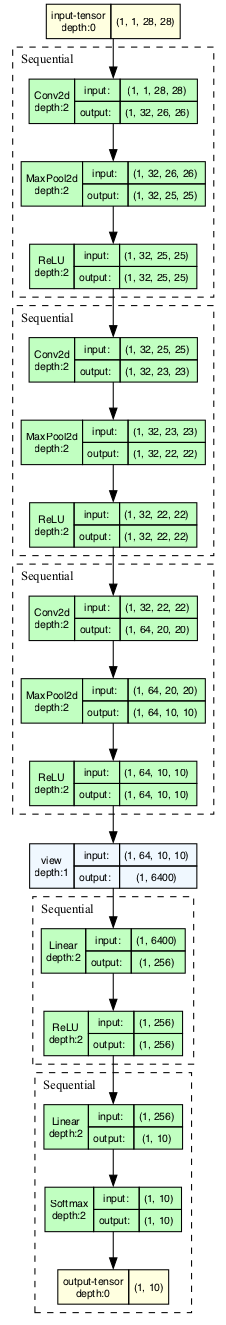

In [9]:
model_parameters = filter(lambda p: p.requires_grad, ConvolutionalNeuralNetwork().parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Total number of parameters: {params}")

model_graph = draw_graph(ConvolutionalNeuralNetwork(), input_size=(1, 1, 28, 28), expand_nested=True)
model_graph.visual_graph


# Experiment

## Loops

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            losses.append(loss.item())
    return losses


def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    losses, accuracy = [], []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X.to(device))
            test_loss = loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.argmax(1).to(device)).type(torch.float).sum().item()

            if batch % 50 == 49:
                losses.append(test_loss)
                accuracy.append(correct / (pred.shape[0]*100))
                correct = 0
    return losses, accuracy

In [7]:
def experiment(train_dataloader, test_dataloader, model, loss_fn, optimizer, run, epochs = 100):
    train_losses, test_losses, test_accuracy = [], [], []
    for epoch in tqdm(range(epochs), desc="Epoch"):
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss = np.mean(train_loss)
        train_losses.append(train_loss)
        run["train/loss"].append(train_loss)

        test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
        test_loss = np.mean(test_loss)
        test_losses.append(test_loss)
        run["test/loss"].append(test_loss)
        test_accuracy += test_acc
        run["test/acc"].append(np.mean(test_acc))
    return train_losses, test_losses, test_accuracy

In [8]:
def init_neptune_run():
    return neptune.init_run(project=os.getenv("NEPTUNE_PROJECT"), 
                            api_token=os.getenv("NEPTUNE_API_TOKEN"), 
                            capture_stdout=False, 
                            capture_stderr=False, 
                            capture_traceback=False, 
                            capture_hardware_metrics=False)

In [9]:
def plot_results(train_losses, test_losses, test_accuracy, name):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    axs[0].plot(train_losses, label= "train")
    axs[0].plot(test_losses, label="test")
    axs[0].legend()
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Training and test losses")

    axs[1].plot(test_accuracy)
    axs[1].set_xlabel("3 values per epoch (every 50th batch)")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Test accuracy")
    plt.suptitle(name)
    plt.show()

## Runs

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/alessandro1802/MLT/e/MLT-6


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/alessandro1802/MLT/e/MLT-6/metadata


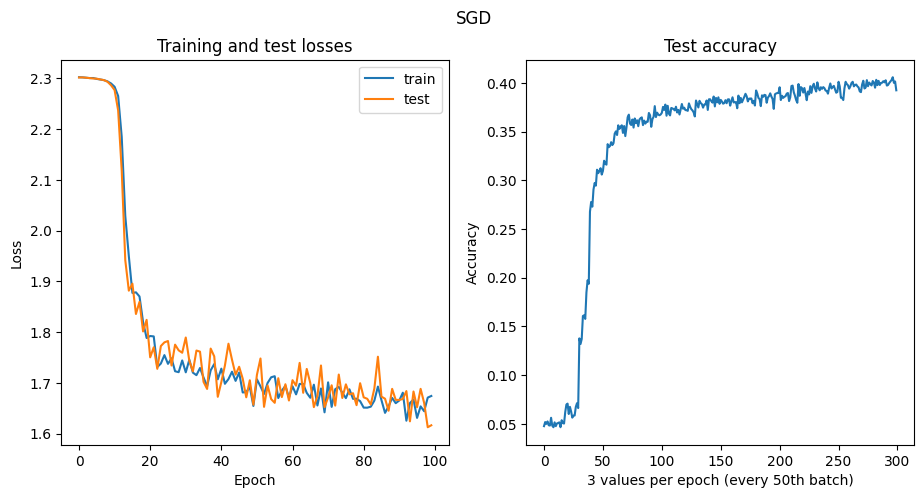

In [10]:
model = ConvolutionalNeuralNetwork().to(device)
run = init_neptune_run()
run["parameters"] = {"optimizer": "SGD"}
train_losses, test_losses, test_accuracy = experiment(train_dataloader, test_dataloader,
                                                      model, nn.CrossEntropyLoss().to(device),
                                                      torch.optim.SGD(model.parameters(), lr=1e-3),
                                                      run)
run.stop()
plot_results(train_losses, test_losses, test_accuracy, "SGD")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/alessandro1802/MLT/e/MLT-7


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/alessandro1802/MLT/e/MLT-7/metadata


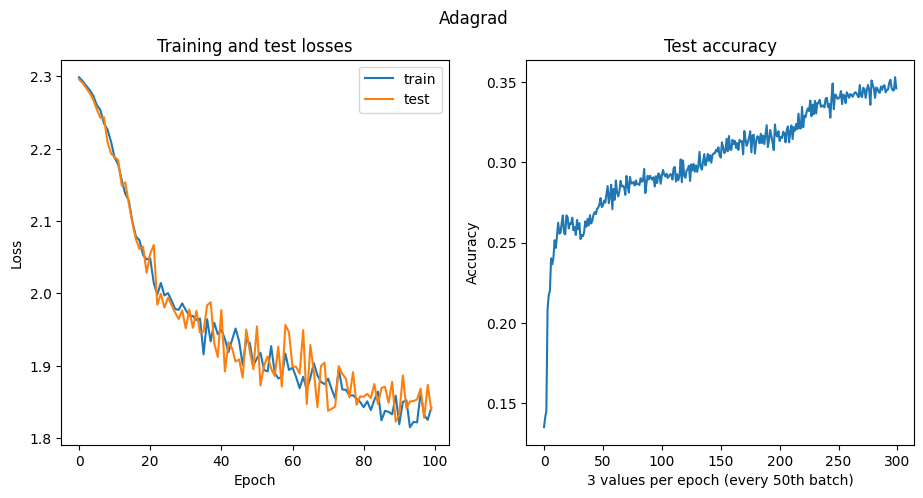

In [11]:
model = ConvolutionalNeuralNetwork().to(device)
run = init_neptune_run()
run["parameters"] = {"optimizer": "Adagrad"}
train_losses, test_losses, test_accuracy = experiment(train_dataloader, test_dataloader,
                                                      model, nn.CrossEntropyLoss().to(device),
                                                      torch.optim.Adagrad(model.parameters(), lr=1e-5),
                                                      run)
run.stop()
plot_results(train_losses, test_losses, test_accuracy, "Adagrad")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/alessandro1802/MLT/e/MLT-8


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/alessandro1802/MLT/e/MLT-8/metadata


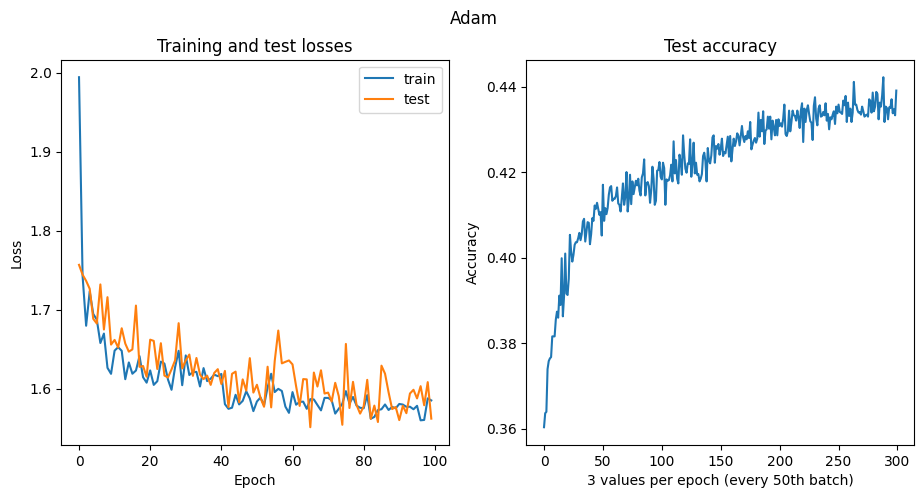

In [12]:
model = ConvolutionalNeuralNetwork().to(device)
run = init_neptune_run()
run["parameters"] = {"optimizer": "Adam"}
train_losses, test_losses, test_accuracy = experiment(train_dataloader, test_dataloader,
                                                      model, nn.CrossEntropyLoss().to(device),
                                                      torch.optim.Adam(model.parameters(), lr=1e-5),
                                                      run)
run.stop()
plot_results(train_losses, test_losses, test_accuracy, "Adam")